MNIST: 
- 60k training images, 10k test images <br>
- Contains handwritten single digits from 0 to 9, a single digit image can be represented as a array, 28x28 pixels; values represent the grayscale image <br>
- Feed into network: reshape the MNIST data from a 28x28 image to a flattened 1x784 vector to mimic a single row of 784 features.
#### Cons: Flattening out the image ends up removing some of the 2D information, such as the relationship of a pixel to neighboring pixels 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency

In [3]:
from torch.utils.data import DataLoader  #load data in batches
from torchvision import datasets, transforms

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
#MNIST >> TENSORS
transform = transforms.ToTensor() #define tranform 

In [15]:
#Load the training set
train_data = datasets.MNIST(root = 'C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data', train = True, download= True, transform=transform)

In [16]:
#Load test set
test_data = train_data = datasets.MNIST(root = 'C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data', train = False, download= True, transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/thomtt10/Documents/PRACTICE_CODE/Pytorch_Udemy/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [9]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [11]:
type(train_data[0])

tuple

In [19]:
image, label = train_data[0]
print('shape: ',image.shape) 
print('label', label)


shape:  torch.Size([1, 28, 28])
label 7


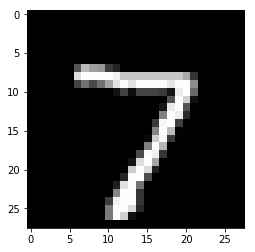

In [20]:
#view image 
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

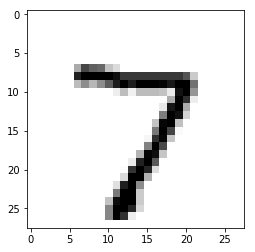

In [21]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

## Batch loading with DataLoader
Our training set contains 60,000 records. If we look ahead to our model we have 784 incoming features, hidden layers of 120 and 84 neurons, and 10 output features. Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\begin{split}\quad(784\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
94080+120+10080+84+840+10 &= 105,214\end{split}$<br>

For this reason it makes sense to load training data in batches using <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [23]:
torch.manual_seed(101)  # for consistent results
"""
train_data: Pytorch dataset object
batch_size: number of records to be processed at a time 
shuffle= True means that the dataset will be shuffled after each epoch
"""
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

### View a batch of images
- Define a DataLoader
- Create a grid of images using torchvision.utils.make_grid

Labels:  [   8    9    7    5    2    7    3    6    4    9    5    7]


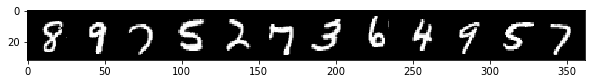

In [24]:

from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Define the model 
- Use fully connected layers to develop a multilayer perceptron 
- Input size: 784
- Output size : 10 represents the 10 possible digits
- Set hidden layers to [120, 84]

In [25]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [27]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model 

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
"""
layerlist = []
for i in layers:
    layerlist.append(nn.Linear(n_in,i)) 
    layerlist.append(nn.ReLU(inplace=True))
self.layers = nn.Sequential(*layerlist)


def forward(self,X):
    X = F.relu(self.fc1(X))
"""


'\nlayerlist = []\nfor i in layers:\n    layerlist.append(nn.Linear(n_in,i)) \n    layerlist.append(nn.ReLU(inplace=True))\nself.layers = nn.Sequential(*layerlist)\n\n\ndef forward(self,X):\n    X = F.relu(self.fc1(X))\n'

# Count the model parameters
Shows that the number of trainable parameters 

In [30]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [31]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


### Define loss function & Optimizer


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Flatten the training data
batch tensor fed in by DataLoader have a shape of [100, 1, 28, 28]

In [33]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([100, 1, 28, 28])


In [34]:
# EQUIVALENT TO
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


In [35]:
#flatten using .view()
images.view(100,-1).size()

torch.Size([100, 784])

# Train the model 
Notw 
predicted = torch.max(y_pred.data,1)[1] <br>
Function torch.max() returns a tensor of maximum values, and a tensor of the indices where the max values were found. 

In [39]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            


Duration: 51 seconds


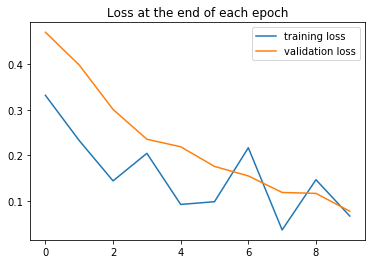

In [37]:
## Plot the loss and acc comaparisons
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

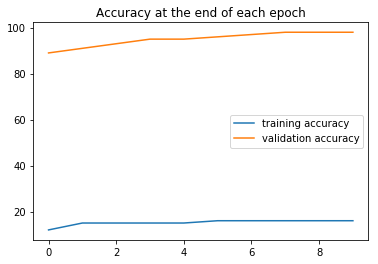

In [38]:
# overfitting the validation data 
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [40]:
#Evaluate test data
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9878), tensor(9908), tensor(9928), tensor(9950), tensor(9969), tensor(9969), tensor(9986), tensor(9992), tensor(9991), tensor(9995)]

Test accuracy: 99.950%


In [41]:
# Compare the predicted values to the ground truth (y_test label)
# Run test set through the trained model all at once 
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [42]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9995/10000 =  99.950%


In [43]:
# Display the confusion matrix 
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))
# >> show that the model had the greatest success with 1, 2, 7 and lowest with 5,6,8

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    0 1032    0    0    0    0    0    0    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0    0  982    0    0    0    1    4]
 [   0    0    0    0    0  892    0    0    0    0]
 [   0    0    0    0    0    0  958    0    0    0]
 [   0    0    0    0    0    0    0 1028    0    0]
 [   0    0    0    0    0    0    0    0  973    0]
 [   0    0    0    0    0    0    0    0    0 1005]]


In [44]:
# Examine the misses 
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

5

In [45]:
# Display the first 10 index positions
misses[:10]

array([1232, 3869, 4956, 9587, 9890], dtype=int64)

In [46]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [1232 3869 4956 9587 9890]
Label: [   9    9    8    9    9]
Guess: [   4    4    4    4    4]


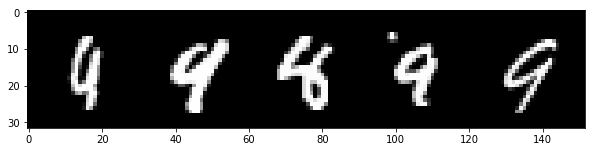

In [47]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));